In [28]:
import matplotlib.pyplot as plt

from hdf5storage import loadmat, savemat 

import numpy as np


In [29]:
# load syn_pcorr
outdict=loadmat('pcorr_subj.mat')
pcorr=outdict["pcorr"]
likelihood=outdict["likelihood"]

In [30]:
# covert to bool
nonzerosmat=np.zeros(np.shape(pcorr))
for subj in range(2):
    for ses in range(12):
        nonzerosmat[subj][ses]=pcorr[subj][ses].astype(bool)

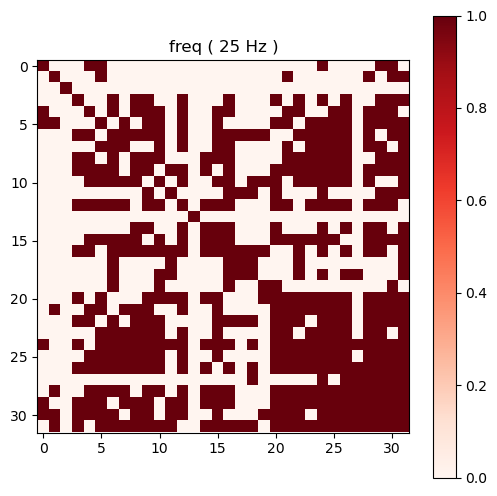

In [31]:
# a selected a freq to examine the distribution
freq=25
fig, ax = plt.subplots(1,1,figsize=(6, 6))
plt.imshow(nonzerosmat[subj,ses,freq,:,:],vmin = 0,vmax = 1,cmap = 'Reds')
plt.title('freq ( ' + str(freq) + ' Hz )')
plt.colorbar()


In [32]:
# compute number of edges
numEdges_subj=np.zeros((2,12,30))
for subj in range(2):
    for ses in range(12):
        for freq in range(30):
            numEdges_subj[subj][ses][freq]=(np.sum(nonzerosmat[subj][ses][freq])-32)/2

In [38]:
# compare single model and subject model
# load pcorr from single model
outdict=loadmat('..\Pcorr_single_model\pcorr_single.mat')
pcorr_single=outdict["pcorr"]
likelihood_single=outdict["likelihood"]

In [34]:
# covert to bool
nonzerosmat_single=np.zeros(np.shape(pcorr_single))
for freq in range(30):
    nonzerosmat_single[freq]=pcorr_single[freq].astype(bool)

In [35]:
# compute number of edges
numEdges_single=np.zeros((30))
for freq in range(30):
    numEdges_single[freq]=(np.sum(nonzerosmat_single[freq])-32)/2

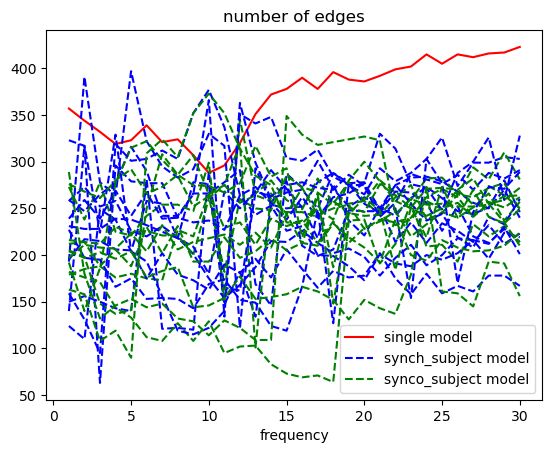

In [36]:
# import pylab

singleplt=plt.plot(np.arange(1,31),numEdges_single, 'r', label='single model')
plt.title('number of edges')

for subj in range(2):
    for ses in list(range(0,12,2)): # synch [0, 2, 4, 6, 8, 10]
        if subj==0 and ses==0:
            synchplt=plt.plot(np.arange(1,31),numEdges_subj[subj][ses], 'b--', label='synch_subject model')
        else:
            synchplt=plt.plot(np.arange(1,31),numEdges_subj[subj][ses], 'b--', label=str())
            
    for ses in list(range(1,12,2)): # [1, 3, 5, 7, 9, 11]
        if subj==0 and ses==1:
            syncoplt=plt.plot(np.arange(1,31),numEdges_subj[subj][ses], 'g--', label='synco_subject model')
        else:
            syncoplt=plt.plot(np.arange(1,31),numEdges_subj[subj][ses], 'g--', label=str())


plt.xlabel('frequency')

plt.legend()

plt.show()

In [68]:
np.shape(numEdges_subj)

(2, 12, 30)

In [73]:
np.mean(np.mean(numEdges_subj[:,list(range(0,12,2)),:],axis=1),axis=0)

array([208.16666667, 236.91666667, 204.41666667, 250.33333333,
       243.91666667, 247.58333333, 225.75      , 211.33333333,
       220.75      , 245.83333333, 210.91666667, 229.16666667,
       234.91666667, 236.83333333, 244.66666667, 242.        ,
       241.5       , 238.        , 246.91666667, 241.91666667,
       244.75      , 244.66666667, 238.58333333, 249.25      ,
       243.75      , 234.75      , 237.5       , 246.58333333,
       247.66666667, 248.41666667])

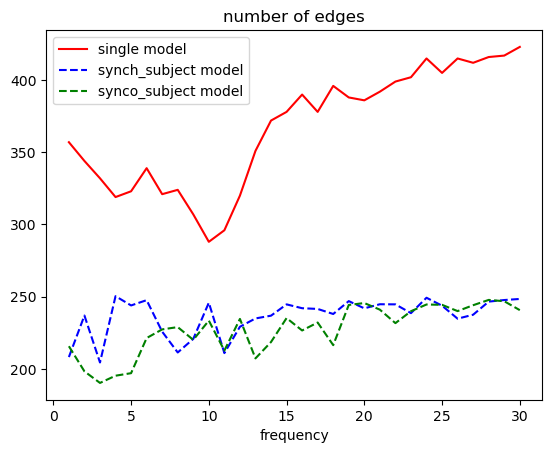

In [74]:
# import pylab

singleplt=plt.plot(np.arange(1,31),numEdges_single, 'r', label='single model')
plt.title('number of edges')

synchplt=plt.plot(np.arange(1,31),\
    np.mean(np.mean(numEdges_subj[:,list(range(0,12,2)),:],axis=1),axis=0), \
        'b--', label='synch_subject model')
        
syncoplt=plt.plot(np.arange(1,31),\
    np.mean(np.mean(numEdges_subj[:,list(range(1,12,2)),:],axis=1),axis=0), \
        'g--', label='synco_subject model')


plt.xlabel('frequency')

plt.legend()

plt.show()

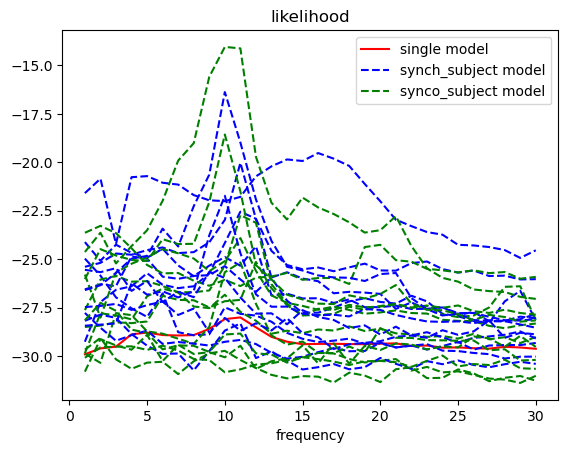

In [39]:
# import pylab

singleplt=plt.plot(np.arange(1,31),likelihood_single, 'r', label='single model')
# pylab.legend([singleplt],['single model likelihood'],loc = 'upper left')
plt.title('likelihood')

for subj in range(2):
    for ses in list(range(0,12,2)): # synch [0, 2, 4, 6, 8, 10]
        if subj==0 and ses==0:
            synchplt=plt.plot(np.arange(1,31),likelihood[subj][ses], 'b--', label='synch_subject model')
        else:
            synchplt=plt.plot(np.arange(1,31),likelihood[subj][ses], 'b--', label=str())
            
    for ses in list(range(1,12,2)): # [1, 3, 5, 7, 9, 11]
        if subj==0 and ses==1:
            syncoplt=plt.plot(np.arange(1,31),likelihood[subj][ses], 'g--', label='synco_subject model')
        else:
            syncoplt=plt.plot(np.arange(1,31),likelihood[subj][ses], 'g--', label=str())


# pylab.legend([synchplt],['synch_subject model'],loc = 'upper left')
# pylab.legend([syncoplt],['synco_subject model'],loc = 'upper left')
plt.xlabel('frequency')

plt.legend()

plt.show()

re_estimate_ggmFitHtf

In [40]:
import numpy as np
import warnings
from hdf5storage import loadmat,savemat
from matplotlib import pyplot as plt
from scipy.stats import sem

In [41]:
def convergence_test(fval, previous_fval, threshold=1e-4, warn=False):
    """
    Check if an objective function has converged.

    We have converged if the slope of the function falls below 'threshold',
    i.e., |f(t) - f(t-1)| / avg < threshold,
    where avg = (|f(t)| + |f(t-1)|)/2.
    'threshold' defaults to 1e-4.
    This stopping criterion is from Numerical Recipes in C p423.
    """

    converged = False
    delta_fval = np.abs(fval - previous_fval)
    avg_fval = (np.abs(fval) + np.abs(previous_fval) + np.finfo(float).eps) / 2

    if delta_fval / avg_fval < threshold:
        converged = True

    if warn and (fval - previous_fval) < -2 * np.finfo(float).eps:  # fval < previous_fval
        warnings.warn('objective decreased!', UserWarning)

    return converged

In [42]:
def ggmFitHtf(S, G, maxIter=30):
    # MLE for a precision matrix given known zeros in the graph
    # S is d*d sample covariance matrix
    # G is d*d adjacency matrix
    # We use the algorithm due to 
    # Hastie, Tibshirani & Friedman ("Elements" book, 2nd Ed, 2008, p633)
    # This file is from pmtk3.googlecode.com
    p = S.shape[0] 
    W = S # W = inv(precMat)
    precMat = np.zeros((p, p))
    beta = np.zeros(p-1)
    iter = 1
    converged = False
    normW = np.linalg.norm(W)
    while not converged:
        for i in range(p):
            # partition W & S for i
            noti = np.concatenate((np.arange(i), np.arange(i+1, p)))
            W11 = W[noti,:][:,noti]
            w12 = W[noti,i]
            s22 = S[i,i]
            s12 = S[noti,i]

            # find G's non-zero index in W11
            idx = np.nonzero(G[noti,i])[0]  # non-zeros in G11
            beta[:] = 0
            beta[idx] = np.linalg.solve(W11[np.ix_(idx,idx)], s12[idx])

            # update W
            w12 = W11 @ beta
            W[noti,i] = w12 
            W[i,noti] = w12

            # update precMat (technically only needed on last iteration)
            p22 = max([0,  1/(s22 - w12 @ beta)])  # must be non-neg
            p12 = -beta * p22
            precMat[noti,i] = p12
            precMat[i,noti] = p12
            precMat[i,i] = p22

        converged = convergence_test(np.linalg.norm(W),normW) | (iter > maxIter)
        normW = np.linalg.norm(W)
        iter += 1

    # ensure symmetry 
    precMat = (precMat + precMat.T)/2
    
    return precMat, iter


re-estimate the 12 session x 2 subjects x 12 trial using ggmFitHtf

In [43]:
# load pcorr_single 
# General: a single model for all
data = loadmat('../Pcorr_single_model/pcorr_single.mat')
singlepcorr = data['pcorr']

In [44]:
# organize file in time sequence
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)
# file directory of the pcorr output for each session
filedir="../Pcorr_trial_level/" # your own data directory
pathname = 'pcorr/'
dir=filedir+pathname

In [ ]:
re_parcor_all=np.zeros([12,12,2,30,32,32])
iter_all=np.zeros([12,12,2,30,32,32])

for ses in range(12):
	filename='clean_'+str(filedates[ses])+'_pcorr.mat'
	spectral=loadmat(dir+filename)
	ampcorr = spectral['empirical_amplitude_correlation']
	for trl in range(12):
		for subj in range(2):
			for freq in range(30):
				# single trial
				S = ampcorr[subj,trl,freq,:,:]
				# subject model
				x = pcorr[subj, ses, freq,:,:]
				G = x.astype('bool')
				G = G.astype('int')
				# re-estimate
				precMat,iter = ggmFitHtf(S, G, maxIter=100)
				y = np.diag(precMat)
				yy = np.outer(y,y)
				yy = np.sqrt(yy)
				parcor = precMat/yy 
				re_parcor_all[ses,trl,subj,freq,:,:]=parcor
				iter_all[ses,trl,subj,freq,:,:]=iter

# takes 1.5 min	
								

In [ ]:
# save
outdict=dict()
outdict['re_parcor_all']=re_parcor_all
outdict['iter_all']=iter_all
savemat('re_estimate',outdict,store_python_metadata=True)

orgainize into 2syn4condi

In [46]:
import numpy as np
import warnings
from hdf5storage import loadmat,savemat
from matplotlib import pyplot as plt
from scipy.stats import sem

In [47]:
# load 
outdict=loadmat('re_estimate.mat')
re_parcor_all=outdict["re_parcor_all"]
iter_all=outdict["iter_all"]
del(outdict)

In [48]:
# load condition_all
outdict=loadmat('../Pcorr_trial_level/conditions_all.mat')
conditions_all=outdict["conditions_all"]

# Organize indicies 
Uncoupled_Ind=np.zeros((12,3))
L_Lead_Ind=np.zeros((12,3)) # they were leading indicies for L subject but following for R
R_Lead_Ind=np.zeros((12,3))
Mutual_Ind=np.zeros((12,3))

for ses in range(12):
    Uncoupled_Ind[ses]=np.asarray(np.where(conditions_all[ses]==1))
    L_Lead_Ind[ses]=np.asarray(np.where(conditions_all[ses]==2))
    R_Lead_Ind[ses]=np.asarray(np.where(conditions_all[ses]==3))
    Mutual_Ind[ses]=np.asarray(np.where(conditions_all[ses]==4))

In [49]:
#  re_parcor_all into 4 conditions in 2 syn types
# append all trials of the same condition together
synch_Uncoupled = [[] for i in range(30)]
synch_Leading   = [[] for i in range(30)]
synch_Following = [[] for i in range(30)]
synch_Mutual    = [[] for i in range(30)]

synco_Uncoupled = [[] for i in range(30)]
synco_Leading   = [[] for i in range(30)]
synco_Following = [[] for i in range(30)]
synco_Mutual    = [[] for i in range(30)]


for ses in list(range(0,12,2)): # synch [0, 2, 4, 6, 8, 10]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    synch_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synch_Leading[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Following[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])
                else:
                    synch_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synch_Leading[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Following[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])

for ses in list(range(1,12,2)): # [1, 3, 5, 7, 9, 11]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    synco_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synco_Leading[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Following[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])
                else:
                    synco_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synco_Leading[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Following[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])

# appended 36 trials in each frequencies for each conditions

In [50]:
synch_4condi=[synch_Uncoupled ,
              synch_Leading   ,
              synch_Following ,
              synch_Mutual    ]
synco_4condi=[synco_Uncoupled ,
              synco_Leading   ,
              synco_Following ,
              synco_Mutual    ]
syn_4condi=[synch_4condi, synco_4condi]

In [51]:
# mean of the re_parcor matricies in each frequency across 36 trial
mean_syn_4condi=np.zeros((2,4,30,32,32))
for syn in range(2):
    for condi in range(4):
        for freq in range(30):
            mean_syn_4condi[syn,condi,freq,:,:] = (np.asarray(syn_4condi[syn][condi][freq])).mean(0)


In [52]:
# sem of the re_parcor matricies in each frequency across 36 trial
sem_syn_4condi = np.zeros((2,4,30,32,32))
for syn in range(2):
    for condi in range(4):
        for freq in range(30):
            sem_syn_4condi[syn,condi,freq,:,:] = sem(np.asarray(syn_4condi[syn][condi][freq]))


In [53]:
# extract the mean and sem of pcorr for each edge in the 30 freqs.
mean30f_syn_4condi=np.zeros((2,4,496,30))
sem30f_syn_4condi =np.zeros((2,4,496,30))

n=0
# for each edge
for i in range(32):
    for j in range (32):
        if i<j: # upper half of the matrix

            for syn in range(2):
                for condi in range(4):
                    mean30f_syn_4condi[syn,condi,n,:]=mean_syn_4condi[syn,condi,:,i,j]
                    sem30f_syn_4condi [syn,condi,n,:]=sem_syn_4condi [syn,condi,:,i,j]
            n += 1



In [ ]:
# save
outdict=dict()
outdict['mean30f_syn_4condi']=mean30f_syn_4condi
outdict['sem30f_syn_4condi']=sem30f_syn_4condi
savemat('mean30f_sem30f_2syn_4condi',outdict,store_python_metadata=True)

In [54]:
import numpy as np
import warnings
from hdf5storage import loadmat,savemat
from matplotlib import pyplot as plt
from scipy.stats import sem
import networkx as nx

from matplotlib.backends.backend_pdf import PdfPages

In [55]:
# function for printing figures into Pdf file
# https://www.geeksforgeeks.org/save-multiple-matplotlib-figures-in-single-pdf-file-using-python/

def save_image(filename):
    
    # PdfPages is a wrapper around pdf 
    # file so there is no clash and
    # create files with no error.
    p = PdfPages(filename)
      
    # get_fignums Return list of existing
    # figure numbers
    fig_nums = plt.get_fignums()  
    figs = [plt.figure(n) for n in fig_nums]
      
    # iterating over the numbers in list
    for fig in figs: 
        
        # and saving the files
        fig.savefig(p, format='pdf') 
          
    # close the object
    p.close()  



In [56]:
# load condition_all
outdict=loadmat('mean30f_sem30f_2syn_4condi.mat')
mean30f_syn_4condi=outdict["mean30f_syn_4condi"]
sem30f_syn_4condi=outdict["sem30f_syn_4condi"]



In [57]:
# construct edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [58]:
# load chan locs for topoplots
dict_loc=loadmat('../Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']

In [59]:
syn2names=['synch','synco']
states4names=['Uncoupled','Leading','Following','Mutual']
color_4st=['green','red','blue','black']

plot 8 networkx in each for each frequency

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


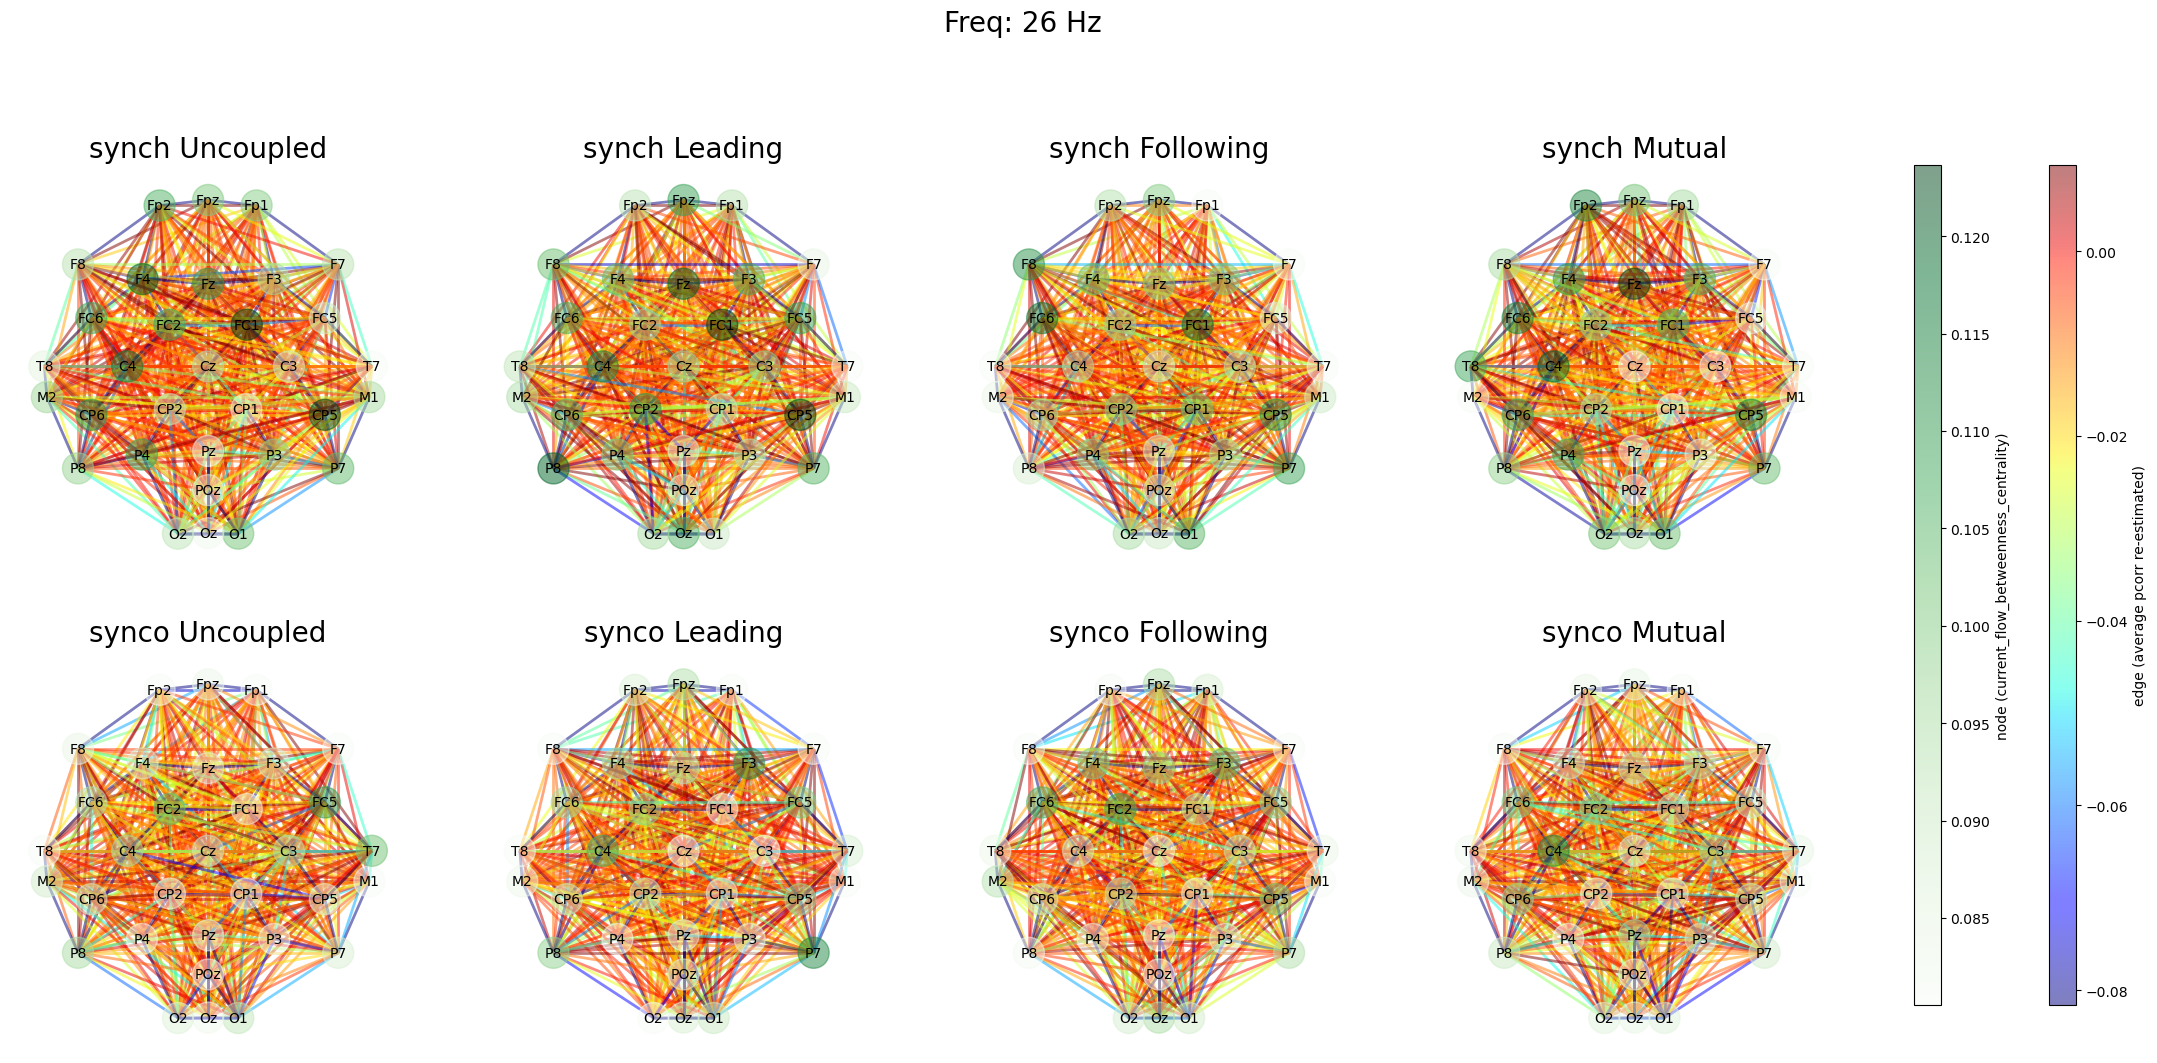

In [60]:
# select a freq to investigate
for freq in range(25,26):

        fig, ax = plt.subplots(2,4,figsize=(6*4+3, 6*2))

        for syn in range(2):
                for condi in range(4):
                        weights=mean30f_syn_4condi[syn][condi][:,freq]
                        non0_edges=list()
                        for i in range(len(edges_list)): # 496
                                if weights[i] != 0:
                                        non0_edges.append(edges_list[i]+({'weight': weights[i]},))
                        # networkx initiate with edges
                        X = nx.Graph()
                        X.add_edges_from(non0_edges)
                        edges,non0_weights = zip(*nx.get_edge_attributes(X,'weight').items())

                        centrality = nx.current_flow_betweenness_centrality(X, weight='weight')
                        node_colors=[n for n in centrality.values()]

                        # set colorbar limits for node and edge from the 1st subplot
                        if syn==0 and condi ==0:
                                vmin_node_c=min(node_colors)#+0.9*(max(node_colors)-min(node_colors))
                                vmax_node_c=max(node_colors)#-0.45*(max(node_colors)-min(node_colors))
                                vmin_edge_c=min(weights)+0.75*(max(weights)-min(weights))
                                vmax_edge_c=max(weights)-0.05*(max(weights)-min(weights))
                        
                        # subplot
                        plt.sca(ax[syn, condi])

                        nx.draw_networkx_labels(X, pos, labels=labeldict, font_size=10)

                        nodes=nx.draw_networkx_nodes(X, pos, node_size=500, 
                                node_color=node_colors, vmin=vmin_node_c, vmax=vmax_node_c, 
                                cmap='Greens', alpha=0.5)

                        edges=nx.draw_networkx_edges(X, pos, width=2, 
                                edge_color=non0_weights,edge_vmin=vmin_edge_c,edge_vmax=vmax_edge_c,
                                edge_cmap=plt.cm.jet,alpha=0.5)
                        
                        ax[syn, condi].set_title(syn2names[syn] + ' ' + states4names[condi],
                                                fontsize = 20) 
                        ax[syn, condi].axis('off')

        fig.subplots_adjust(right=0.8)
        cbar_ax1 = fig.add_axes([0.83, 0.15, 0.01, 0.7])
        cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.7])

        cbar_node=fig.colorbar(nodes,cbar_ax1)
        cbar_node.ax.tick_params(labelsize=10)
        cbar_node.set_label('node (current_flow_betweenness_centrality)')

        cbar_edges=fig.colorbar(edges,cbar_ax2)
        cbar_edges.ax.tick_params(labelsize=10)
        cbar_edges.set_label('edge (average pcorr re-estimated)')

        fig.subplots_adjust(top=0.85)
        fig.suptitle('Freq: ' + str(freq+1) + ' Hz', fontsize = 20) 


# print into Pdf file
paffilename = "freq30_pcorr_networkx.pdf"
save_image(paffilename)

